In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'E:\DBDA PRJ\Training'
valid_path = 'E:\DBDA PRJ\Testing'

In [4]:
# Import the ResNet50 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [6]:
# useful for getting number of output classes
folders = glob('E:\DBDA PRJ\Training\*')

In [7]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [8]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)
len(model.trainable_variables)

2

In [9]:
# view the structure of the model
#model.build([None, 224, 224, 3])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [10]:
# tell the model what cost and optimization method to use

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [11]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Make sure you provide the same target size as initialied for the image size


training_set = train_datagen.flow_from_directory('E:\DBDA PRJ\Training',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2125 images belonging to 6 classes.


In [13]:
test_set = test_datagen.flow_from_directory('E:\DBDA PRJ\Testing',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 620 images belonging to 6 classes.


In [14]:
for image_batch, label_batch in training_set:
      break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 6))

In [15]:
print (training_set.class_indices)

labels = '\n'.join(sorted(training_set.class_indices.keys()))

with open('labels.txt', 'w') as f:
      f.write(labels)

{'Bulging_Eyes': 0, 'Cataracts': 1, 'Crossed_Eyes': 2, 'Glaucoma': 3, 'NORMAL': 4, 'Uveitis': 5}


In [16]:
save_best_only = True
from keras.callbacks import ModelCheckpoint , EarlyStopping

mc = ModelCheckpoint(filepath='E/restnet50/',                     
                     verbose=1,
                     save_best_only = True) 

ec = EarlyStopping(
                  min_delta=0.01,
                  patience=5,
                  verbose=1)
                   
    
cb = [mc , ec]

In [17]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=100,
  callbacks=cb,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\gaura\AppData\Local\Temp\ipykernel_13992\840779726.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
17/67 [======>.......................] - ETA: 4:55 - loss: 1.8464 - accuracy: 0.2518

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.6567 - accuracy: 0.3111
Epoch 1: val_loss improved from inf to 1.59709, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 542s 8s/step - loss: 1.6567 - accuracy: 0.3111 - val_loss: 1.5971 - val_accuracy: 0.2581
Epoch 2/100
45/67 [===================>..........] - ETA: 2:12 - loss: 1.4933 - accuracy: 0.3549

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.4970 - accuracy: 0.3515
Epoch 2: val_loss did not improve from 1.59709
67/67 [==============================] - 470s 7s/step - loss: 1.4970 - accuracy: 0.3515 - val_loss: 1.7884 - val_accuracy: 0.2629
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 1.4611 - accuracy: 0.3572
Epoch 3: val_loss improved from 1.59709 to 1.58675, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 524s 8s/step - loss: 1.4611 - accuracy: 0.3572 - val_loss: 1.5867 - val_accuracy: 0.3532
Epoch 4/100
 5/67 [=>............................] - ETA: 6:23 - loss: 1.3264 - accuracy: 0.4313

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.3970 - accuracy: 0.3967
Epoch 4: val_loss improved from 1.58675 to 1.58121, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 514s 8s/step - loss: 1.3970 - accuracy: 0.3967 - val_loss: 1.5812 - val_accuracy: 0.3597
Epoch 5/100
50/67 [=====================>........] - ETA: 1:35 - loss: 1.4016 - accuracy: 0.3947

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.4057 - accuracy: 0.3939
Epoch 5: val_loss did not improve from 1.58121
67/67 [==============================] - 459s 7s/step - loss: 1.4057 - accuracy: 0.3939 - val_loss: 1.7949 - val_accuracy: 0.3758
Epoch 6/100
67/67 [==============================] - ETA: 0s - loss: 1.3786 - accuracy: 0.3962
Epoch 6: val_loss improved from 1.58121 to 1.39540, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 510s 8s/step - loss: 1.3786 - accuracy: 0.3962 - val_loss: 1.3954 - val_accuracy: 0.3629
Epoch 7/100
17/67 [======>.......................] - ETA: 4:38 - loss: 1.3253 - accuracy: 0.4191

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.3145 - accuracy: 0.4221
Epoch 7: val_loss improved from 1.39540 to 1.36274, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 511s 8s/step - loss: 1.3145 - accuracy: 0.4221 - val_loss: 1.3627 - val_accuracy: 0.3823
Epoch 8/100
50/67 [=====================>........] - ETA: 1:35 - loss: 1.3122 - accuracy: 0.4257

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.3089 - accuracy: 0.4254
Epoch 8: val_loss improved from 1.36274 to 1.34005, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 508s 8s/step - loss: 1.3089 - accuracy: 0.4254 - val_loss: 1.3401 - val_accuracy: 0.4371
Epoch 9/100
56/67 [========================>.....] - ETA: 1:03 - loss: 1.2856 - accuracy: 0.4337

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.2893 - accuracy: 0.4282
Epoch 9: val_loss did not improve from 1.34005
67/67 [==============================] - 466s 7s/step - loss: 1.2893 - accuracy: 0.4282 - val_loss: 1.5784 - val_accuracy: 0.3565
Epoch 10/100
67/67 [==============================] - ETA: 0s - loss: 1.3253 - accuracy: 0.4221
Epoch 10: val_loss did not improve from 1.34005
67/67 [==============================] - 460s 7s/step - loss: 1.3253 - accuracy: 0.4221 - val_loss: 1.6239 - val_accuracy: 0.3887
Epoch 11/100
67/67 [==============================] - ETA: 0s - loss: 1.3019 - accuracy: 0.4165
Epoch 11: val_loss improved from 1.34005 to 1.25912, saving model to E/restnet50\


INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 508s 8s/step - loss: 1.3019 - accuracy: 0.4165 - val_loss: 1.2591 - val_accuracy: 0.4726
Epoch 12/100
26/67 [==========>...................] - ETA: 4:01 - loss: 1.2769 - accuracy: 0.4279

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


67/67 [==============================] - ETA: 0s - loss: 1.2667 - accuracy: 0.4391
Epoch 12: val_loss did not improve from 1.25912
67/67 [==============================] - 467s 7s/step - loss: 1.2667 - accuracy: 0.4391 - val_loss: 1.2972 - val_accuracy: 0.5145
Epoch 13/100
67/67 [==============================] - ETA: 0s - loss: 1.2679 - accuracy: 0.4405
Epoch 13: val_loss did not improve from 1.25912
67/67 [==============================] - 463s 7s/step - loss: 1.2679 - accuracy: 0.4405 - val_loss: 1.3581 - val_accuracy: 0.4435
Epoch 14/100
67/67 [==============================] - ETA: 0s - loss: 1.2648 - accuracy: 0.4452
Epoch 14: val_loss did not improve from 1.25912
67/67 [==============================] - 464s 7s/step - loss: 1.2648 - accuracy: 0.4452 - val_loss: 1.2681 - val_accuracy: 0.4774
Epoch 15/100
67/67 [==============================] - ETA: 0s - loss: 1.2520 - accuracy: 0.4504
Epoch 15: val_loss did not improve from 1.25912
67/67 [==============================] - 458s 7

INFO:tensorflow:Assets written to: E/restnet50\assets


INFO:tensorflow:Assets written to: E/restnet50\assets


67/67 [==============================] - 518s 8s/step - loss: 1.2461 - accuracy: 0.4522 - val_loss: 1.2495 - val_accuracy: 0.5274
Epoch 16: early stopping


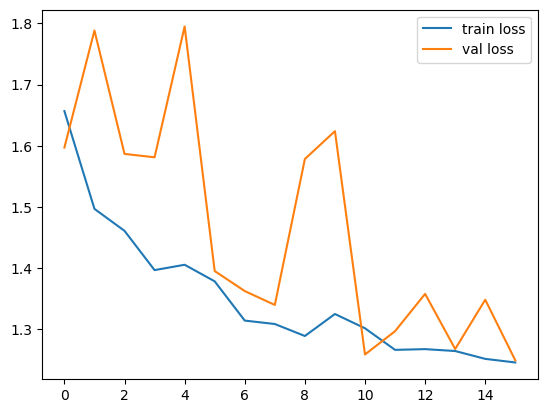

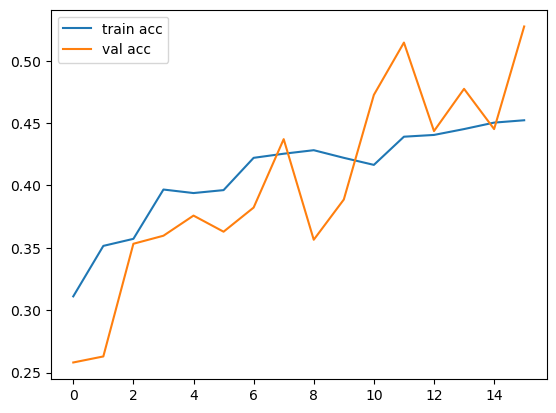

<Figure size 640x480 with 0 Axes>

In [18]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [20]:
y_pred = model.predict(test_set)

C:\Users\gaura\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 [==============================] - 73s 3s/step


In [21]:
y_pred

array([[3.9366011e-02, 1.8309444e-01, 3.8182408e-02, 3.1056452e-01,
        3.4253773e-01, 8.6254828e-02],
       [9.9792711e-02, 1.5886356e-01, 5.6145046e-02, 2.1234848e-01,
        4.5660470e-02, 4.2718980e-01],
       [3.7083435e-06, 9.9894053e-01, 5.2889017e-04, 4.2213438e-04,
        2.4785662e-09, 1.0481143e-04],
       ...,
       [1.3292904e-01, 6.6061459e-02, 1.3518777e-01, 5.4581806e-02,
        1.3866028e-04, 6.1110133e-01],
       [4.0617418e-02, 1.8080357e-01, 3.1348523e-02, 3.0065298e-01,
        3.5258144e-01, 9.3995988e-02],
       [5.8692354e-01, 5.8261603e-02, 1.7091033e-01, 1.1280486e-01,
        5.1656360e-05, 7.1047932e-02]], dtype=float32)

In [25]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1 
y_pred = np.argmax(y_pred, axis=1

SyntaxError: invalid syntax (1474234341.py, line 3)

In [26]:
model=load_model('model_resnet50.h5')